In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


 # Task -- Diagnostics
 In the first homework, we had two issues with the classifiers we built. Namely (1) the data were not shuffled, and (2) the labels were highly imbalanced. Both of these made it difficult to effectively build an accurate classifier. Here we’ll try and correct for those issues using the Bankruptcy dataset.

 ## Problem 1
 Download and parse the bankruptcy data. We’ll use the 5year.arff file. Code to read the data is available in the stub. Train a logistic regressor (e.g. sklearn.linear model.LogisticRegression) with regularization coefficient C = 1.0. Report the accuracy and Balanced Error Rate (BER) of your classifier (1 mark).

In [7]:
# ============ Environment Setup ============
# ignore the warnings
import warnings
warnings.filterwarnings("ignore")
# import some packages
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import numpy as np

# Read the dataset
def myReadData(path): 
    f = open(path, 'r')
    while not '@data' in f.readline():
        pass
    dataset = []
    for l in f:
        if '?' in l: # Missing entry
            continue
        l = l.split(',')
        values = [1] + [float(x) for x in l]
        values[-1] = values[-1] > 0 # Convert to bool
        dataset.append(values)

    # Data setup
    X = [values[:-1] for values in dataset]
    y = [values[-1] for values in dataset]

    return X, y

def myEvaluation(model, X, y):
    # get predictions from model
    pred = model.predict(X)
    
    TP_ = np.logical_and(pred, y)
    FP_ = np.logical_and(pred, np.logical_not(y))
    TN_ = np.logical_and(np.logical_not(pred), np.logical_not(y))
    FN_ = np.logical_and(np.logical_not(pred), y)

    TP = sum(TP_)
    FP = sum(FP_)
    TN = sum(TN_)
    FN = sum(FN_)

    # Accuracy
    correct = pred == y
    print("Accuracy: %.3f" % np.mean(correct))
    # BER
    print("Balanced Error Rate: %.3f" %  (1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))))

X, y = myReadData("./Homework2/data/5year.arff")
# define a logistic regression
model = linear_model.LogisticRegression(C=1.0)
# fit a model
model.fit(X, y)
myEvaluation(model, X, y)


Accuracy: 0.966
Balanced Error Rate: 0.481


 ## Problem 3
 Shuffle the data, and split it into training, validation, and test splits, with a 50/25/25% ratio. Using the class weight=’balanced’ option, and training on the training set, report the training/validation/test accuracy and BER (1 mark).

In [8]:
# import packages
import random
random.seed(5583)

def myShuffle(X, y):
    """ Shuffle the data """
    Xy = list(zip(X,y))
    random.shuffle(Xy)
    X = [d[0] for d in Xy]
    y = [d[1] for d in Xy]
    return X, y

# Train/validation/test splits
def mySplits(X, y):
    N = len(y)

    Ntrain = int(0.5*len(y))
    Nvalid = int(0.25*len(y))
    Ntest = int(0.25*len(y))

    Xtrain = X[:Ntrain]
    Xvalid = X[Ntrain:Ntrain+Nvalid]
    Xtest = X[Ntrain+Nvalid:]

    ytrain = y[:Ntrain]
    yvalid = y[Ntrain:Ntrain+Nvalid]
    ytest = y[Ntrain+Nvalid:]

    return Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest

X, y = myReadData("./Homework2/data/5year.arff")
X, y = myShuffle(X, y)
Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest = mySplits(X, y)
# define a logistic regression
model = linear_model.LogisticRegression(C=1.0, class_weight='balanced')
# fit a model
model.fit(Xtrain, ytrain)
print("=============== Training ===============")
myEvaluation(model, Xtrain, ytrain)    # myEvaluation function was defined in Problem 1 
print("=============== Validating ===============")
myEvaluation(model, Xvalid, yvalid)
print("=============== Testing ===============")
myEvaluation(model, Xtest, ytest)



=============== Training ===============
Accuracy: 0.779
Balanced Error Rate: 0.242
=============== Validating ===============
Accuracy: 0.781
Balanced Error Rate: 0.203
=============== Testing ===============
Accuracy: 0.780
Balanced Error Rate: 0.262


 ## Problem 4
 Implement a complete regularization pipeline with the balanced classifier. Consider values of C in the range $\{10^{−4},10^{−3},...,10^3,10^4\}$. Report (or plot) the train, validation, and test BER for each value of C. Based on these values, which classifier would you select (in terms of generalization performance) and why (1 mark)?

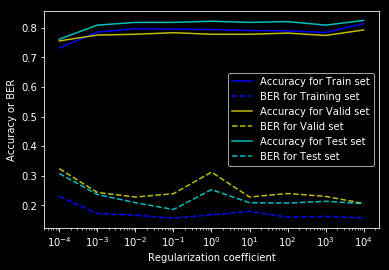

In [9]:
import matplotlib.pyplot as plt

def myEvaluation(model, X, y, acc, ber):
    # get predictions from model
    pred = model.predict(X)
    
    TP_ = np.logical_and(pred, y)
    FP_ = np.logical_and(pred, np.logical_not(y))
    TN_ = np.logical_and(np.logical_not(pred), np.logical_not(y))
    FN_ = np.logical_and(np.logical_not(pred), y)

    TP = sum(TP_)
    FP = sum(FP_)
    TN = sum(TN_)
    FN = sum(FN_)

    correct = pred == y
    # Accuracy
    acc.append(np.mean(correct))
    # BER
    ber.append(1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP)))

def regPipeline(X, y, regs, trainAcc, trainBer, validAcc, validBer, testAcc, testBer):
    X, y = myShuffle(X, y)
    Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest = mySplits(X, y)
    for reg in regs:
        model = linear_model.LogisticRegression(C=reg, class_weight='balanced')
        # fit a model
        model.fit(Xtrain, ytrain)
        myEvaluation(model, Xtrain, ytrain, trainAcc, trainBer)
        myEvaluation(model, Xvalid, yvalid, validAcc, validBer)
        myEvaluation(model, Xtest, ytest, testAcc, testBer)

trainAcc, trainBer, validAcc, validBer, testAcc, testBer = [], [], [], [], [], []
regs = [10**N for N in [-4, -3, -2, -1, 0, 1, 2, 3, 4]]
X, y = myReadData("./Homework2/data/5year.arff")
regPipeline(X, y, regs, trainAcc, trainBer, validAcc, validBer, testAcc, testBer)

plt.plot(regs, trainAcc, 'b-', label='Accuracy for Train set')
plt.plot(regs, trainBer, 'b--', label='BER for Training set')
plt.plot(regs, validAcc, 'y-', label='Accuracy for Valid set')
plt.plot(regs, validBer, 'y--', label='BER for Valid set')
plt.plot(regs, testAcc, 'c-', label='Accuracy for Test set')
plt.plot(regs, testBer, 'c--', label='BER for Test set')
plt.legend()
plt.xlabel('Regularization coefficient')
plt.xscale('log')
plt.ylabel('Accuracy or BER')
plt.show()



 Based on the plot, we will choose $10^0$ since it has the lowest BER for the validation set and meanwhile keeps a high accuracy on both the training and validation set.

 ## Problem 6
 The sample weight option allows you to manually build a balanced (or imbalanced) classifier by assigning different weights to each datapoint (i.e., each label y in the training set). For example, we would assign equal weight to all samples by fitting:

 weights = [1.0] * len(ytrain)

 mod = linear_model.LogisticRegression(C=1, solver=’lbfgs’)

 mod.fit(Xtrain, ytrain, sample_weight=weights)

 (note that you should use the lbfgs solver option, and need not set class weight=’balanced’ in
 this case). Assigning larger weights to (e.g.) positive samples would encourage the logistic regressor to
 optimize for the True Positive Rate. Using the above code, compute the Fβ score (on the test set) of your
 (unweighted) classifier, for β = 1 and β = 10. Following this, identify weight vectors that yield better
 performance (compared to the unweighted vector) in terms of the F1 and F10 scores (2 marks).

=============== None weight =============== 
F Score is 0.242  for Beta 1
F Score is 0.155  for Beta 10
=============== Balanced weight =============== 
F Score is 0.162  for Beta 1
F Score is 0.683  for Beta 10
=============== My weight =============== 


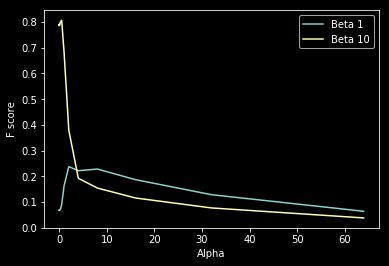

In [10]:
def FBeta(model, Xtest, ytest, beta):
    pred = model.predict(Xtest)
    retrieved = sum(pred)
    relevant = sum(ytest)
    intersection = sum([y and p for y, p in zip(ytest,pred)])
    precision = intersection / retrieved
    recall = intersection / relevant
    F_Beta = (1+beta**2)*(precision*recall)/((beta**2)*precision+recall)
    return F_Beta
    
print("=============== None weight =============== ")
weights = [1.0] * len(ytrain)
model = linear_model.LogisticRegression(C=1.0, solver='lbfgs')
model.fit(Xtrain, ytrain, sample_weight=weights)
print("F Score is %.3f" % FBeta(model, Xtest, ytest, 1), " for Beta 1")
print("F Score is %.3f" % FBeta(model, Xtest, ytest, 10), " for Beta 10")

print("=============== Balanced weight =============== ")
model = linear_model.LogisticRegression(C=1.0, solver='lbfgs', class_weight='balanced')
model.fit(Xtrain, ytrain)
print("F Score is %.3f" % FBeta(model, Xtest, ytest, 1), " for Beta 1")
print("F Score is %.3f" % FBeta(model, Xtest, ytest, 10), " for Beta 10")

print("=============== My weight =============== ")
true_ratio = len([1.0 for y in ytrain if y is True])/len(ytrain)
false_ratio = 1 - true_ratio
alphas = [2**i for i in range(-10, 8)]
Beta_1, Beta_10 = [], []
for alpha in alphas:
    weights = [false_ratio if y is True else true_ratio*alpha for y in ytrain]
    model = linear_model.LogisticRegression(C=1.0, solver='lbfgs')
    model.fit(Xtrain, ytrain, sample_weight=weights)
    Beta_1.append(FBeta(model, Xtest, ytest, 1))
    Beta_10.append(FBeta(model, Xtest, ytest, 10))

plt.plot(alphas, Beta_1, label='Beta 1')
plt.plot(alphas, Beta_10, label='Beta 10')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('F score')
plt.show()



 # Tasks -- Dimensionality Reduction
 Next we’ll consider using PCA to build a lower-dimensional feature vector to do prediction.

 ## Problem 7
 Following the stub code, compute the PCA basis on the training set. Report the first PCA component
 (i.e., pca.components [0])

In [11]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(Xtrain)
print(pca.components_[0])


[-1.76636055e-18 -3.88774766e-08  3.91178524e-07  1.62093982e-06
  9.81592130e-06  6.78648530e-04 -1.52568558e-06  2.31596680e-06
  9.02354365e-06 -1.17215537e-06 -1.28587101e-07  3.39889517e-07
  1.77000649e-06  6.98953943e-07  2.31596680e-06 -8.56732994e-03
  1.67758042e-06  9.72886226e-06  2.31596680e-06  7.33390001e-07
  9.30880022e-05  3.39868608e-07  3.08547249e-07  6.55226551e-07
  5.00167483e-07  9.05428198e-07  1.48632063e-06 -1.76037474e-04
  4.80818029e-05  4.94340305e-06 -2.36427176e-06  7.21586824e-07
 -3.93427090e-04  7.03688492e-06 -2.38631665e-06  2.95736451e-07
 -1.60518909e-06  2.00372698e-03 -7.06985096e-07  2.90046692e-07
  4.62573681e-06 -3.24927526e-06  6.05977982e-07  1.33117229e-04
  4.00277499e-05 -2.76291185e-06  7.12800934e-06  1.39281569e-04
  3.77066322e-07  6.37742025e-07  7.26183476e-06 -1.14274329e-06
 -1.00850645e-06  4.13873094e-06  4.80711918e-05  9.99960858e-01
  2.53489811e-07  1.39209629e-06 -3.57102739e-07 -7.40231098e-07
 -1.77887524e-04 -2.26509

 ## Problem 8
 Next we’ll train a model using a low-dimensional feature vector. By representing the data in the above
 basis, i.e.:

 Xpca_train = np.matmul(Xtrain, pca.components_.T)

 Xpca_valid = np.matmul(Xvalid, pca.components_.T)

 Xpca_test = np.matmul(Xtest, pca.components_.T)

 compute the validation and test BER of a model that uses just the first N components (i.e., dimensions) for N = 5, 10, ... , 25, 30. Again use class weight=’balanced’ and C = 1.0 (2 marks).

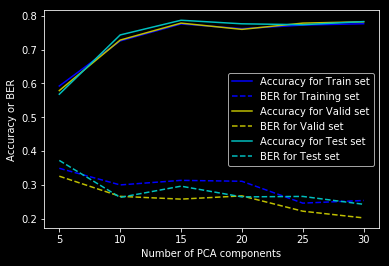

In [12]:
def getLowDimension(N, Xtrain, Xvalid, Xtest):
    Xpca_train = np.matmul(Xtrain, pca.components_[:N].T) 
    Xpca_valid = np.matmul(Xvalid, pca.components_[:N].T) 
    Xpca_test = np.matmul(Xtest, pca.components_[:N].T)
    return Xpca_train, Xpca_valid, Xpca_test

def regPipeline(Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest, trainAcc, trainBer, validAcc, validBer, testAcc, testBer):
    model = linear_model.LogisticRegression(C=1.0, class_weight='balanced')
    model.fit(Xtrain, ytrain)
    myEvaluation(model, Xtrain, ytrain, trainAcc, trainBer)
    myEvaluation(model, Xvalid, yvalid, validAcc, validBer)
    myEvaluation(model, Xtest, ytest, testAcc, testBer)

trainAcc, trainBer, validAcc, validBer, testAcc, testBer = [], [], [], [], [], []
pca = PCA()
pca.fit(Xtrain)
Ns = list(range(5, 35, 5))
for N in Ns:
    Xtrain_lowd, Xvalid_lowd, Xtest_lowd = getLowDimension(N, Xtrain, Xvalid, Xtest)
    regPipeline(Xtrain_lowd, Xvalid_lowd, Xtest_lowd, ytrain, yvalid, ytest, trainAcc, trainBer, validAcc, validBer, testAcc, testBer)

plt.plot(Ns, trainAcc, 'b-', label='Accuracy for Train set')
plt.plot(Ns, trainBer, 'b--', label='BER for Training set')
plt.plot(Ns, validAcc, 'y-', label='Accuracy for Valid set')
plt.plot(Ns, validBer, 'y--', label='BER for Valid set')
plt.plot(Ns, testAcc, 'c-', label='Accuracy for Test set')
plt.plot(Ns, testBer, 'c--', label='BER for Test set')
plt.legend()
plt.xlabel('Number of PCA components')
plt.ylabel('Accuracy or BER')
plt.show()

